# The Midnight mystery: a data mining murder investigation

**Contents**<a id='toc0_'></a>    
1. [Assignment description](#toc1_)    
1.1. [Background](#toc1_1_)    
1.2. [Dataset description](#toc1_2_)    
1.3. [Investigation mission](#toc1_3_)    
1.4. [Technical requirements](#toc1_4_)    
1.5. [Evaluation criteria](#toc1_5_)    
1.6. [Hints](#toc1_6_)    
1.7. [Submission](#toc1_7_)    
2. [Requirements](#toc2_)    
3. [Data loading](#toc3_)    
4. [Data exploration](#toc4_)    
5. [Data extraction](#toc5_)    
6. [Data embedding](#toc6_)    
7. [Embeddings visualization](#toc7_)    
7.1. [2D/3D PCA plots](#toc7_1_)    
7.2. [2D/3D t-SNE plots](#toc7_2_)    
7.3. [2D/3D UMAP plots](#toc7_3_)    
8. [Interactive 3D visualization](#toc8_)    
8.1. [Interactive 3D PCA plot](#toc8_1_)    
8.2. [Interactive 3D t-SNE plot](#toc8_2_)    
8.3. [Interactive 3D UMAP plot](#toc8_3_)    
9. [Embeddings clustering](#toc9_)    
10. [Graph embedding](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Assignment description](#toc0_)
### 1.1. <a id='toc1_1_'></a>[Background](#toc0_)
It's a dark and stormy night at the Grand Hotel. Many distinguished guests have gathered for an exclusive gala. At precisely 11:50 PM, a scream pierces the night - one guest has been murdered!
The legendary detective Sherlock Holmes and his assistant Dr. Watson arrive at the scene. They conduct thorough interviews with all surviving guests. Each guest provides information about their whereabouts at the time of the murder and whom they remember seeing.
A crucial piece of evidence is found: a handwritten note clutched in the victim's hand, apparently torn from the murderer during the struggle. The note appears to be written in a distinctive style.
Your task is to help Holmes and Watson identify the most likely suspects.

### 1.2. <a id='toc1_2_'></a>[Dataset description](#toc0_)
You are provided with `murder_mystery_data.json` containing:
- **Metadata**: Case details including victim name, murder time, and the mysterious note
- **Interrogations**: Interview reports, each containing:
  - Guest name
  - Their statement about location and sightings
  - Interview timestamp

### 1.3. <a id='toc1_3_'></a>[Investigation mission](#toc0_)
You must analyze the evidence to identify the prime suspects. Your investigation should combine your findings from all analyses to:
1. Identify the most likely murderer
2. Provide evidence supporting your conclusion
3. Explain any alternative suspects and why they were ruled out

**Deliverable**: A final report presenting your conclusion with supporting evidence, and the code.

### 1.4. <a id='toc1_4_'></a>[Technical requirements](#toc0_)
- You can use any Python  libraries you like, such as: `networkx`, `python-louvain`, `sentence-transformers`, `openai/anthropic` (via OpenRouter)
- Your code should be well-documented and reproducible
- Handle API rate limits appropriately

### 1.5. <a id='toc1_5_'></a>[Evaluation criteria](#toc0_)
- **Code Quality**: Clean, documented, efficient code
- **Analysis Depth**: Thoroughness of investigation and use of multiple techniques
- **Conclusions**: Logical reasoning and evidence-based conclusions

### 1.6. <a id='toc1_6_'></a>[Hints](#toc0_)
- People may be mistaken as to who they saw
- Some guests might naturally be more isolated due to their behavior or timing
- Writing styles can reveal more than just dialect - look for patterns

### 1.7. <a id='toc1_7_'></a>[Submission](#toc0_)
Submit a Jupyter notebook containing:
1. All code with explanations
2. Your final report as a markdown cell

Openrouter API key:
```
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
```

Good luck, detective! The truth is hidden in the data...

---

## 2. <a id='toc2_'></a>[Requirements](#toc0_)

Let's install the libraries required to run the whole notebook. As a first step, we have to install support libraries needed to successfully install the main dependencies in the subsequent phase.

In [1]:
%pip install pexpect pydevd nbformat openai requests

Note: you may need to restart the kernel to use updated packages.


Now, let's install the main requirements.

In [48]:
%pip install pandas sentence-transformers matplotlib seaborn scikit-learn umap-learn plotly pyclustering hdbscan networkx python-louvain

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9460 sha256=3c955f44e143a593d2471c3135e577735cda44e6680356ec446baca54a627aa5
  Stored in directory: /Users/xequent/Library/Caches/pip/wheels/ee/52/54/7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


Finally, let's set some enviroment variables to configure the notebook execution according to our preferences.

In [3]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "true"
warnings.filterwarnings("ignore")

## 3. <a id='toc3_'></a>[Data loading](#toc0_)

Since the dataset is a plain JSON file, we can load it into a simple array.

In [4]:
import json

with open('dataset.json', 'r') as dataset:
    data = json.load(dataset)
print(json.dumps(data, indent=4))

{
    "metadata": {
        "case_name": "The Midnight Mystery",
        "victim": "Lady Mustard",
        "murder_time": "11:50pm",
        "victim_note": "Ye cannae hide forever behind yer mask of respectability. I ken aboot the debts, the gambling, the desperate measures ye took tae maintain yer position. The banker telt me everythin' afore he died - yes, I ken aboot that too. Hoo many mair secrets are ye hiding? Hoo many mair fowk hae ye hurt? I am giving ye one final chance tae come clean. Meet me at the appointed hour and bring the account books. We will find a way throo this mess, but only if ye stop lying. The truth, however painful, is our only salvation.",
        "detective": "Sherlock Holmes",
        "assistant": "Dr. Watson",
        "total_guests": 20,
        "interrogated": 19,
        "locations": [
            "library",
            "ballroom",
            "conservatory",
            "billiard room",
            "study",
            "hall",
            "lounge",
    

Alternatively, we can use a Pandas dataframe to load the same content.

In [5]:
from pandas import json_normalize

df = json_normalize(data)
print(df.head())

                                      interrogations    metadata.case_name  \
0  [{'guest': 'Sir Gray', 'statement': 'At that t...  The Midnight Mystery   

  metadata.victim metadata.murder_time  \
0    Lady Mustard              11:50pm   

                                metadata.victim_note metadata.detective  \
0  Ye cannae hide forever behind yer mask of resp...    Sherlock Holmes   

  metadata.assistant  metadata.total_guests  metadata.interrogated  \
0         Dr. Watson                     20                     19   

                                  metadata.locations solution.murderer  \
0  [library, ballroom, conservatory, billiard roo...                 ?   

  solution.red_herring solution.murder_location  
0                    ?                   cellar  


## 4. <a id='toc4_'></a>[Data exploration](#toc0_)

The dataset is small, and it has a simple structure.

In [6]:
print(json.dumps(data, indent=4))

{
    "metadata": {
        "case_name": "The Midnight Mystery",
        "victim": "Lady Mustard",
        "murder_time": "11:50pm",
        "victim_note": "Ye cannae hide forever behind yer mask of respectability. I ken aboot the debts, the gambling, the desperate measures ye took tae maintain yer position. The banker telt me everythin' afore he died - yes, I ken aboot that too. Hoo many mair secrets are ye hiding? Hoo many mair fowk hae ye hurt? I am giving ye one final chance tae come clean. Meet me at the appointed hour and bring the account books. We will find a way throo this mess, but only if ye stop lying. The truth, however painful, is our only salvation.",
        "detective": "Sherlock Holmes",
        "assistant": "Dr. Watson",
        "total_guests": 20,
        "interrogated": 19,
        "locations": [
            "library",
            "ballroom",
            "conservatory",
            "billiard room",
            "study",
            "hall",
            "lounge",
    

Basically, we have 3 main fields:
- `metadata`: contains some interesting details about the case, for example the note left by the victim, which will be critical during our investigations
- `interrogations`: a transcription of the interrogations of the potential suspects (i.e. the 19 guests)
- `solution`: the only field which seems interesting is the location of the murder (i.e. the cellar)

### Interrogations questions

All the interrogations are visibly constructed answering 4 reverse-engineerable questions:
1. Where were you at 11:50pm, the time at which the murder was committed?
2. Who was there with you, and at which time?
3. What was your reaction when you discovered that a murder was committed?
4. What do you note about the note in the victim hands?

The answer to these questions reconstruct a global dynamic, and we can exploit the interrogations statements in order to build back this dynamic using data analysis techniques.

For the moment, we feel that no other exploration is actually needed. Hence, we can now proceed to extract only the information relevant for our investigative purposes.

## 5. <a id='toc5_'></a>[Data extraction](#toc0_)

Now we have to focus on the main content of our dataset: interrogations. Let's extract and store them into a dedicated array, whose entries are dictionaries of 3 keys: `guest`, `timestamp`, and `statement`.

In [7]:
interrogations = [
    {
        "guest": entry["guest"],
        "timestamp": entry["timestamp"].replace("Interview conducted at ", ""),
        "statement": entry["statement"]
    }
    for entry in data.get("interrogations", [])
]

for i, item in enumerate(interrogations, 1):
    print(f"{i}. {item}")

1. {'guest': 'Sir Gray', 'timestamp': '1:36am', 'statement': "At that time, I was in the hall. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I saw several people actually - Ambassador Azure, Ambassador Black, General Brown, Admiral Mustard, Colonel Coral and General Azure. Everyone seemed to be going about their usual business. I was terrified when I heard about what happened. I'm afraid I can't help you with any note. I didn't write one, didn't receive one, and didn't see one."}
2. {'guest': 'Madame Peacock', 'timestamp': '6:55am', 'statement': "Well, I can tell you exactly where I was - in the smoking room, listening to music. I remember because I was there from about 11:30pm until well after midnight. I noticed Ambassador Green was there too. They didn't stay long, just passed through. I couldn't process it when I heard about what happened. I don't know anything about a note. This is the first I'm hearing of it, and I can assure you I

Let's proceed extracting from the `metadata` and `solution` fields all the details relevant to the investigation. We will store them in the `case` dictionary.

In [8]:
metadata = data.get("metadata", {})
solution = data.get("solution", {})

case = {
    "identifier": metadata.get("case_name"),
    "victim": metadata.get("victim"),
    "murder_time": metadata.get("murder_time"),
    "murder_place": solution.get("murder_location").title(),
    "evidence": metadata.get("victim_note"),
    "detective": metadata.get("detective"),
    "no_guests": metadata.get("total_guests"),
    "no_interrogations": metadata.get("interrogated")
}

print(json.dumps(case, indent=4))

{
    "identifier": "The Midnight Mystery",
    "victim": "Lady Mustard",
    "murder_time": "11:50pm",
    "murder_place": "Cellar",
    "evidence": "Ye cannae hide forever behind yer mask of respectability. I ken aboot the debts, the gambling, the desperate measures ye took tae maintain yer position. The banker telt me everythin' afore he died - yes, I ken aboot that too. Hoo many mair secrets are ye hiding? Hoo many mair fowk hae ye hurt? I am giving ye one final chance tae come clean. Meet me at the appointed hour and bring the account books. We will find a way throo this mess, but only if ye stop lying. The truth, however painful, is our only salvation.",
    "detective": "Sherlock Holmes",
    "no_guests": 20,
    "no_interrogations": 19
}


## 6. <a id='toc6_'></a>[Data embedding](#toc0_)

For the moment we will focus only on the interrogations statements and on the retrieved evidence (i.e. the victim note). In particular, we can create an `investigation` array composed of dictionary entries, each with 4 keys: `name`, `role`, `statement` and `embedding`. This dictionary will contain only the information that can be used as an index (`name` and `role`) or that be meaningfully embedded (`statement`). The `embedding` field is a predisposition to store later the statement embeddings.

In [9]:
# Insert the suspects information
investigation = [
    {
        "name": entry["guest"],
        "role": "suspect",
        "statement": entry["statement"],
        "embedding": []
    }
    for entry in interrogations
]

# Insert the victim information
investigation.append(
    {
        "name": case["victim"],
        "role": "victim",
        "statement": case["evidence"],
        "embedding": []
    }
)

for entry in investigation:
    print(entry)

{'name': 'Sir Gray', 'role': 'suspect', 'statement': "At that time, I was in the hall. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I saw several people actually - Ambassador Azure, Ambassador Black, General Brown, Admiral Mustard, Colonel Coral and General Azure. Everyone seemed to be going about their usual business. I was terrified when I heard about what happened. I'm afraid I can't help you with any note. I didn't write one, didn't receive one, and didn't see one.", 'embedding': []}
{'name': 'Madame Peacock', 'role': 'suspect', 'statement': "Well, I can tell you exactly where I was - in the smoking room, listening to music. I remember because I was there from about 11:30pm until well after midnight. I noticed Ambassador Green was there too. They didn't stay long, just passed through. I couldn't process it when I heard about what happened. I don't know anything about a note. This is the first I'm hearing of it, and I can assure you 

Let's now embed the `statement` contents, storing for each entry the relative statement embedding in the eponymous `embedding` field. Given that we need to embed only 20 statements, we will use **all-mpnet-base-v2** as our encoding transformer model, which generally provides the best quality for semantic similarity comparisons.

In [10]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
model = SentenceTransformer('all-mpnet-base-v2')

for entry in investigation:
    embedding = model.encode(entry["statement"])
    entry["embedding"] = embedding.tolist()

for entry in investigation:
    print(f"{entry["name"]}: {entry["embedding"]}")

Sir Gray: [0.05160839855670929, -0.006673618219792843, 0.0025242227129638195, 0.07036764174699783, 0.023436352610588074, -0.025851620361208916, -0.001572450972162187, 0.034919850528240204, -0.02615852653980255, 0.009639079682528973, -0.04432963952422142, -0.040344223380088806, 0.003536784555763006, -0.08138271421194077, 0.03380824252963066, 0.01988997869193554, 0.036087848246097565, -0.02485712245106697, 0.028590643778443336, -0.003877781331539154, -0.003005334408953786, 0.008595836348831654, -0.023354945704340935, 0.006107121706008911, 0.000142456847243011, 0.05033748224377632, -0.021595150232315063, 0.02565949037671089, -0.00047600778634659946, -0.017599720507860184, -0.01235662866383791, 0.004540960770100355, -0.0043923258781433105, -0.024696817621588707, 1.9962515125371283e-06, 0.034255754202604294, -0.012428516522049904, 0.023947831243276596, -0.03145085647702217, -0.06506829708814621, 0.0044327424839138985, -0.018310924991965294, -0.05275648459792137, -0.0362197570502758, 0.01731

## 7. <a id='toc7_'></a>[Embeddings visualization](#toc0_)

Before applying some form of clustering to the obtained embeddings, we can visualize them in their raw form. In this way, we can try to get an intuition of the statements similarity before and after the clustering phase.

Let's extract from the `investigation` array the embeddings, the useful labels (just 'suspect' or 'victim' is fine) and the names of the involved characters.

In [11]:
import numpy

embeddings = numpy.array([entry["embedding"] for entry in investigation])
labels = [entry["role"] for entry in investigation]  # 'suspect' or 'victim'
names = [entry["name"] for entry in investigation]

### 7.1. <a id='toc7_1_'></a>[2D/3D PCA plots](#toc0_)
Let's see a 2-dimensional plot done via Principal Component Analysis (PCA):

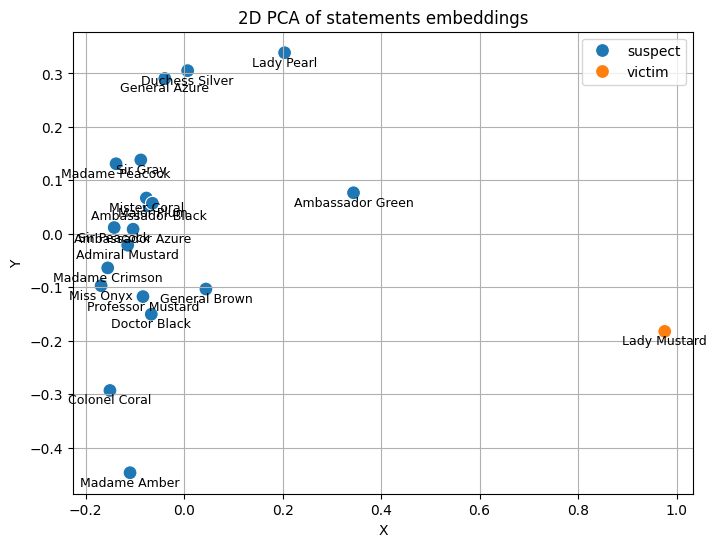

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot
import seaborn

pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(embeddings)

h_offset = 0
v_offset = -0.025

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_pca[:,0], y=reduced_pca[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_pca[i, 0] + h_offset, reduced_pca[i, 1] + v_offset, name, fontsize=9, ha='center')
plot.title("2D PCA of statements embeddings")
plot.xlabel("X")
plot.ylabel("Y")
plot.legend()
plot.grid(True)
plot.show()

The 2D PCA gives us an initial intuition, but we can do a 3D PCA plot to better interpret the embeddings similiarity.

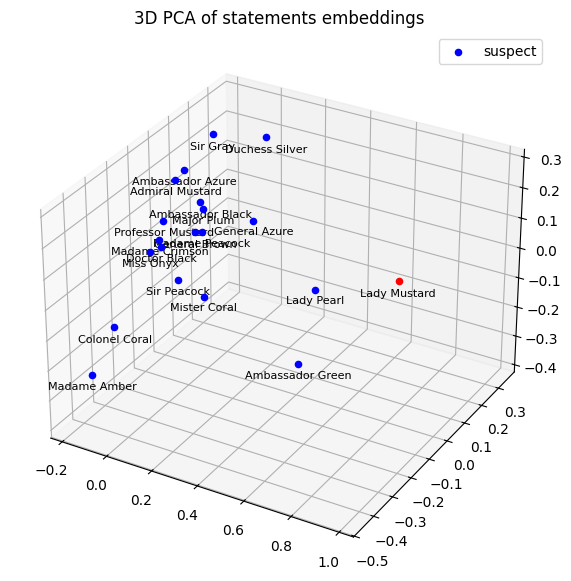

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plot  # renamed from plt

pca3d = PCA(n_components=3)
reduced_3d_pca = pca3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_pca)):
    x, y, z = reduced_3d_pca[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color, label=labels[i] if i == 0 else "")
    
    z_offset = -0.05
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D PCA of statements embeddings")
plot.legend()
plot.show()

This 3D plot shows that the evidence left by Lady Mustard is particularly similar to two statements (i.e. those of Lady Pearl and Ambassador Green). Hence, we have two initial suspects!

### 7.2. <a id='toc7_2_'></a>[2D/3D t-SNE plots](#toc0_)

Now let's use t-SNE.

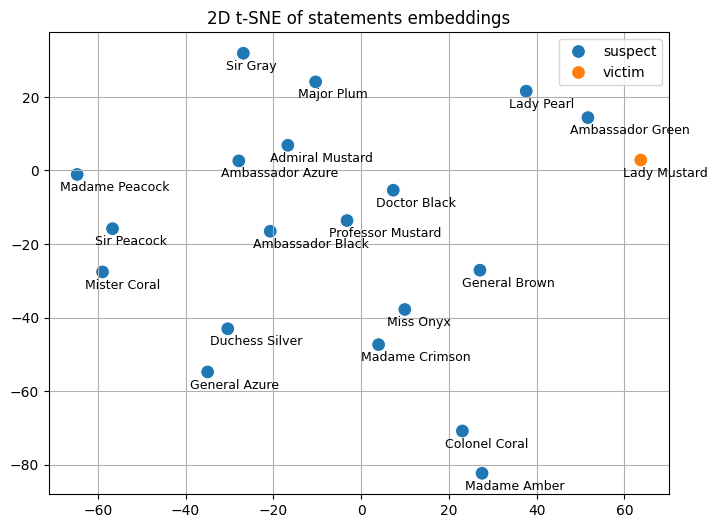

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_tsne = tsne.fit_transform(embeddings)

h_offset = -4.0
v_offset = -4.5

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_tsne[:,0], y=reduced_tsne[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_tsne[i, 0] + h_offset, reduced_tsne[i, 1] + v_offset, name, fontsize=9)
plot.title("2D t-SNE of statements embeddings")
plot.grid(True)
plot.show()

This plot suggests the same two candidate murderers! Let's see what kind of plot we can get using 3D t-SNE.

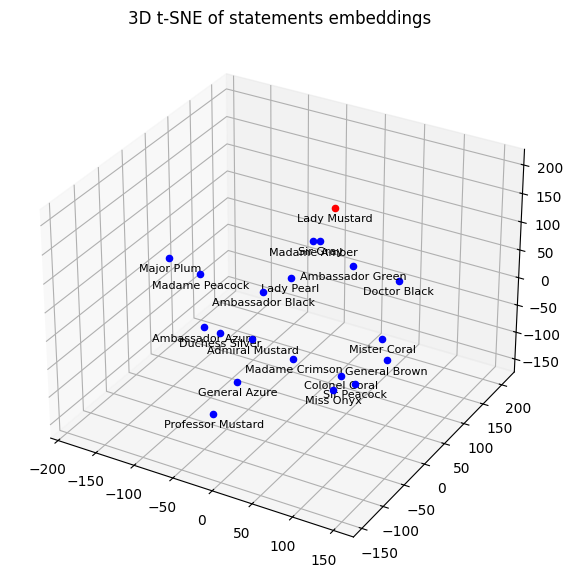

In [15]:
tsne_3d = TSNE(n_components=3, perplexity=5, random_state=42)
reduced_3d_tsne = tsne_3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_tsne)):
    x, y, z = reduced_3d_tsne[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color)
    z_offset = -25
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D t-SNE of statements embeddings")
plot.show()

Not bad, but the 2D visualization is still a little bit clearer. Let's also employ UMAP to see if there are differences.

### 7.3. <a id='toc7_3_'></a>[2D/3D UMAP plots](#toc0_)

Finally, let's use UMAP.

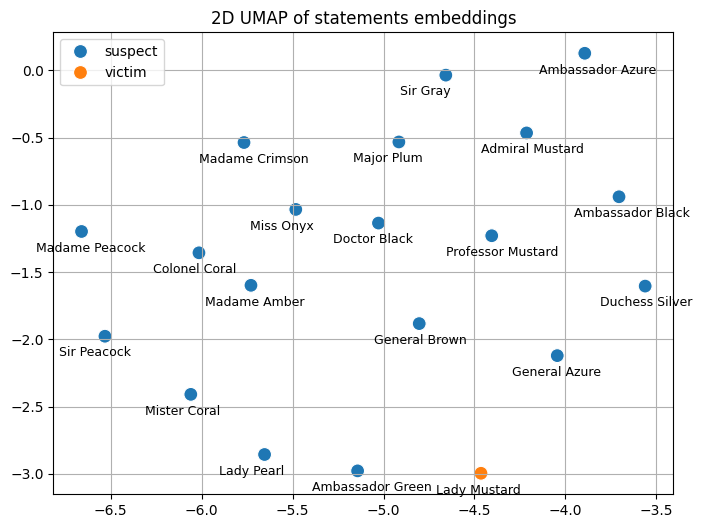

In [16]:
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_umap = umap_reducer.fit_transform(embeddings)

h_offset = -0.250
v_offset = -0.150

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_umap[:,0], y=reduced_umap[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_umap[i, 0] + h_offset, reduced_umap[i, 1] + v_offset, name, fontsize=9)
plot.title("2D UMAP of statements embeddings")
plot.grid(True)
plot.show()

Even this plot shows the same story: Lady Pearl and Ambassador Green statements are the closest to the victim note statement.

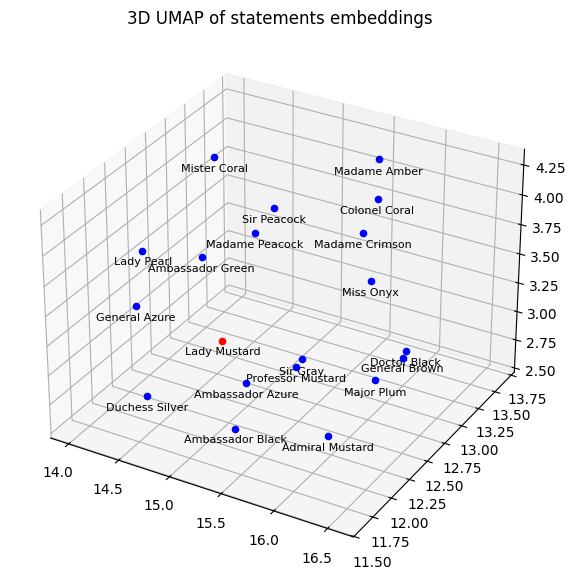

In [17]:
import umap

umap_3d = umap.UMAP(n_components=3, random_state=42)
reduced_3d_umap = umap_3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_umap)):
    x, y, z = reduced_3d_umap[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color)
    z_offset = -0.125
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D UMAP of statements embeddings")
plot.show()

The 3D UMAP plot is a little bit more confusing, but this can just depend on the visualization perspective. Now, let's see if an interactive 3D plotting confirms the intuition deduced from the 2D plots.

## 8. <a id='toc8_'></a>[Interactive 3D visualization](#toc0_)

We will now use `plotly` to create an interactive visualization of the 3D PCA, t-SNE and UMAP plots.

In [18]:
import pandas
import plotly.express as px

def plot_3d_interactive(reduced_data, method_name):
    df = pandas.DataFrame(reduced_data, columns=['X', 'Y', 'Z'])
    df['name'] = names
    df['role'] = labels

    fig = px.scatter_3d(
        df,
        x='X', y='Y', z='Z',
        color='role',
        text='name',
        hover_data=['name', 'role'],
        title=f"3D {method_name} of statements embeddings"
    )
    fig.update_traces(marker=dict(size=6), textposition='bottom center')
    fig.show()


As we can see, the subsequent sections show that the interactive version of the 3D plot confirms that Lady Pearl and Ambassador Green are the two main suspects. Let's see the results below.

### 8.1. <a id='toc8_1_'></a>[Interactive 3D PCA plot](#toc0_)

In [19]:
pca = PCA(n_components=3)
reduced_pca = pca.fit_transform(embeddings)
plot_3d_interactive(reduced_pca, "Interactive 3D PCA")

### 8.2. <a id='toc8_2_'></a>[Interactive 3D t-SNE plot](#toc0_)

In [20]:
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
reduced_tsne = tsne.fit_transform(embeddings)
plot_3d_interactive(reduced_tsne, "t-SNE")

### 8.3. <a id='toc8_3_'></a>[Interactive 3D UMAP plot](#toc0_)

In [21]:
umap_reducer = umap.UMAP(n_components=3, random_state=42)
reduced_umap = umap_reducer.fit_transform(embeddings)
plot_3d_interactive(reduced_umap, "UMAP")

## 9. <a id='toc9_'></a>[Embeddings clustering](#toc0_)

Let's apply some clustering now. We will explore results coming from the application of two common methods: **hdbscan** and **k-means** clustering.

In [22]:
def plot_clusters(reduced_data, cluster_labels, title):
    plot.figure(figsize=(8, 6))
    seaborn.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, palette="tab10", s=100)
    for i, name in enumerate(names):
        plot.text(
            reduced_data[i, 0],
            reduced_data[i, 1] - 0.035,
            name,
            fontsize=9,
            ha='center'
        )
    plot.title(title)
    plot.grid(True)
    plot.show()

pca = PCA(n_components=10)
reduced_pca = pca.fit_transform(embeddings)

First, let's try hdbscan, since we do not have to specify the number of clusters we desire.

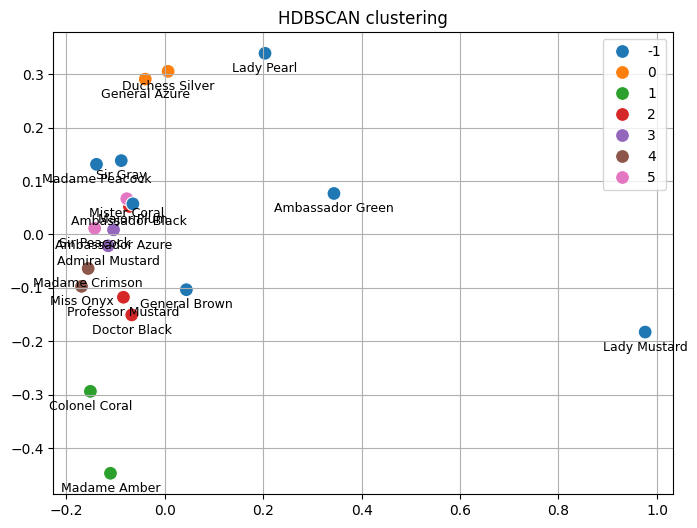

In [23]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
hdb_labels = hdb.fit_predict(embeddings)
plot_clusters(reduced_pca, hdb_labels, "HDBSCAN clustering")

Interestingly, hdbscan finds that Lady Mustard, Ambassador Green, Lady Pearl and some others are noisy datapoints, and are not directly put into a cluster. Let's see what we can get from k-means clustering, then.

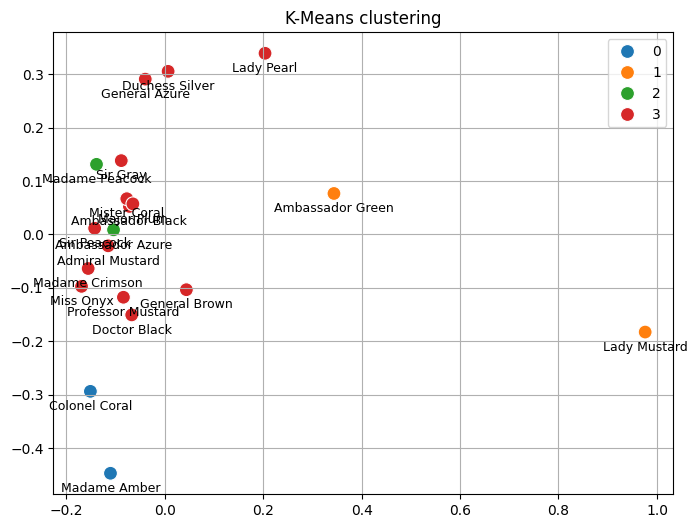

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

plot_clusters(reduced_pca, kmeans_labels, "K-Means clustering")

Here, both Lady Mustard and Ambassador Green belong to the same cluster. Maybe we are getting closer to a unique suspect!

## 10. <a id='toc10_'></a>[Graph embedding](#toc0_)

Now we have enough knowledge about our dataset, and well as some hypothesis on who is the murderer. Let's continue our analysis embedding our dataset into a graph, in order to spot not yet discovered relations.

A first attempt could be to model the guests relationships using the sightings each one of them have attested. This can be done just by extending our `investigation` data structure to also store these sightings, and use it in the next steps.

In [25]:
names = [entry["name"] for entry in investigation]

for entry in investigation:
    own_name = entry["name"]
    # Find names mentioned in the statement;
    # we will exclude a guest own name
    sightings = [
        name for name in names
        if name != own_name and name in entry["statement"]
    ]
    entry["sighting"] = sightings

for entry in investigation:
    print(f"{entry["name"]}: {entry["sighting"]}")


Sir Gray: ['General Azure', 'Admiral Mustard', 'Ambassador Black', 'Ambassador Azure', 'General Brown', 'Colonel Coral']
Madame Peacock: ['Ambassador Green']
Lady Pearl: []
Ambassador Green: ['Madame Amber', 'Madame Crimson']
General Azure: ['Professor Mustard', 'Doctor Black', 'Ambassador Azure', 'Miss Onyx', 'Sir Peacock', 'Mister Coral', 'Major Plum']
Professor Mustard: ['General Azure', 'Doctor Black', 'Admiral Mustard', 'General Brown', 'Miss Onyx', 'Sir Peacock', 'Mister Coral']
Doctor Black: ['General Azure', 'Madame Amber', 'Madame Crimson', 'Miss Onyx', 'Sir Peacock', 'Mister Coral', 'Major Plum']
Madame Amber: ['Sir Gray', 'Admiral Mustard', 'Ambassador Black', 'Ambassador Azure', 'General Brown', 'Miss Onyx', 'Duchess Silver', 'Major Plum']
Admiral Mustard: ['Sir Gray', 'Lady Pearl', 'General Azure', 'Madame Amber', 'Ambassador Azure', 'General Brown', 'Colonel Coral', 'Miss Onyx', 'Duchess Silver']
Ambassador Black: ['Sir Gray', 'Madame Amber', 'Admiral Mustard', 'Ambassado

The actual problem now is connected to the `location` of each guest, because sightings make sense only if they are grounded on a certain location. Let's include the location information in the `investigation` data structure.

In [26]:
# Get the list of locations
locations = metadata.get("locations")

for entry in investigation:
    matching_locations = [
        location for location in locations
        if location in entry["statement"]
    ]
    entry["location"] = matching_locations

for entry in investigation:
    print(f"{entry["name"]}: {entry["location"]}")

Sir Gray: ['hall']
Madame Peacock: ['smoking room']
Lady Pearl: ['hall']
Ambassador Green: ['cellar']
General Azure: ['study']
Professor Mustard: ['terrace']
Doctor Black: ['library']
Madame Amber: ['garden']
Admiral Mustard: ['dining room']
Ambassador Black: ['kitchen']
Ambassador Azure: ['ballroom']
Madame Crimson: ['gallery']
General Brown: ['lounge']
Colonel Coral: ['ballroom']
Miss Onyx: ['kitchen']
Duchess Silver: ['study']
Sir Peacock: ['smoking room']
Mister Coral: ['attic']
Major Plum: ['cellar']
Lady Mustard: []


Let's recap what we know:
- the location where the guest was at the time of the murder
- the sightings of each guest, referred as locations

What we still miss is the timeframe collected from the guest statements. This last point would give us the possibility to understand a global picture of what the characters were **actually** doing when the murder was committed. This extraction is a little bit more difficult, because we cannot rely on fixed strings to be matched in a deterministic way. The viable alternative is to use an LLM to extract this information, and enrich the `investigation` data structure accordingly.

In [ ]:
from openai import OpenAI
import requests

openrouter_api_key = ""
model = "openai/gpt-4.1"

headers = {
    "Authorization": f"Bearer {openrouter_api_key}",
    "Content-Type": "application/json"
}

def extract_time(statement):
    prompt = (
        "Extract the time mentioned or implied in the following statement. "
        "Convert the am/pm notation into flat 24h format (e.g. 11:50pm -> 23:50)"
        "Return only the time range referenced in the format <start_time>-<end_time>;"
        "as an example: '23:50-00:30')."
        "Note that expressions like 'I was there at that time' or similar means that"
        "you should set the <start_time> to '23:45'. If the <end_time> is unclear, set"
        "it to '00:30'. The format <start_time>-<end_time> is mandatory. The angular"
        "brackets must not be present. An example of valid output is '21:00-00:30'.\n\n"
        f"Statement:\n{statement}\n\nAnswer:"
    )
    body = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }

    response = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=body)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"].strip()
    elif response.status_code == 401:
        return "23:45-23:50"
    else:
        print("Error:", response.status_code, response.text)
        return "error"

In [50]:
for entry in investigation:
    entry["timeframe"] = extract_time(entry["statement"])
    if entry["name"] == "Lady Mustard":
        entry["timeframe"] = "23:45-23:50"

for entry in investigation:
    print(f"{entry["name"]}: {entry["timeframe"]}")

Sir Gray: 23:45-23:50
Madame Peacock: 23:45-23:50
Lady Pearl: 23:45-23:50
Ambassador Green: 23:45-23:50
General Azure: 23:45-23:50
Professor Mustard: 23:45-23:50
Doctor Black: 23:45-23:50
Madame Amber: 23:45-23:50
Admiral Mustard: 23:45-23:50
Ambassador Black: 23:45-23:50
Ambassador Azure: 23:45-23:50
Madame Crimson: 23:45-23:50
General Brown: 23:45-23:50
Colonel Coral: 23:45-23:50
Miss Onyx: 23:45-23:50
Duchess Silver: 23:45-23:50
Sir Peacock: 23:45-23:50
Mister Coral: 23:45-23:50
Major Plum: 23:45-23:50
Lady Mustard: 23:45-23:50


Now it is sufficient to create a numerical timeframe interval using the information extracted by the LLM.

In [51]:
from datetime import datetime

def time_to_minutes(t):
    dt = datetime.strptime(t, "%H:%M")
    return dt.hour * 60 + dt.minute

for entry in investigation:
    start_time, end_time = entry["timeframe"].split("-")
    start_minute = time_to_minutes(start_time)
    end_minute = time_to_minutes(end_time)

    # Handle wrap-around at midnight
    if end_minute <= start_minute:
        end_minute += 24 * 60

    entry["interval"] = (start_minute, end_minute)

In [52]:
# Print the numeric timeframe conversion format
for entry in investigation:
    print(f"{entry["timeframe"]}  →  {entry["interval"]} :: {entry["name"]}")

23:45-23:50  →  (1425, 1430) :: Sir Gray
23:45-23:50  →  (1425, 1430) :: Madame Peacock
23:45-23:50  →  (1425, 1430) :: Lady Pearl
23:45-23:50  →  (1425, 1430) :: Ambassador Green
23:45-23:50  →  (1425, 1430) :: General Azure
23:45-23:50  →  (1425, 1430) :: Professor Mustard
23:45-23:50  →  (1425, 1430) :: Doctor Black
23:45-23:50  →  (1425, 1430) :: Madame Amber
23:45-23:50  →  (1425, 1430) :: Admiral Mustard
23:45-23:50  →  (1425, 1430) :: Ambassador Black
23:45-23:50  →  (1425, 1430) :: Ambassador Azure
23:45-23:50  →  (1425, 1430) :: Madame Crimson
23:45-23:50  →  (1425, 1430) :: General Brown
23:45-23:50  →  (1425, 1430) :: Colonel Coral
23:45-23:50  →  (1425, 1430) :: Miss Onyx
23:45-23:50  →  (1425, 1430) :: Duchess Silver
23:45-23:50  →  (1425, 1430) :: Sir Peacock
23:45-23:50  →  (1425, 1430) :: Mister Coral
23:45-23:50  →  (1425, 1430) :: Major Plum
23:45-23:50  →  (1425, 1430) :: Lady Mustard


We now have the complete information about each guest. Let's print the first row of the `investigation` data structure:

In [53]:
guest = investigation[0]

print(f"""
name: {guest["name"]}
role: {guest["role"]}
statement: {guest["statement"]}
embedding: {guest["embedding"]}
sighting: {guest["sighting"]}
location: {guest["location"]}
timeframe: {guest["timeframe"]}
interval: {guest["interval"]}
""")


name: Sir Gray
role: suspect
statement: At that time, I was in the hall. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I saw several people actually - Ambassador Azure, Ambassador Black, General Brown, Admiral Mustard, Colonel Coral and General Azure. Everyone seemed to be going about their usual business. I was terrified when I heard about what happened. I'm afraid I can't help you with any note. I didn't write one, didn't receive one, and didn't see one.
embedding: [0.05160839855670929, -0.006673618219792843, 0.0025242227129638195, 0.07036764174699783, 0.023436352610588074, -0.025851620361208916, -0.001572450972162187, 0.034919850528240204, -0.02615852653980255, 0.009639079682528973, -0.04432963952422142, -0.040344223380088806, 0.003536784555763006, -0.08138271421194077, 0.03380824252963066, 0.01988997869193554, 0.036087848246097565, -0.02485712245106697, 0.028590643778443336, -0.003877781331539154, -0.003005334408953786, 0.0085958363

Now we can model everything using a graph.

In [ ]:
import networkx as nx

investigation_graph = nx.Graph()

for entry in investigation:
    investigation_graph.add_node(
        entry["name"],
        role = entry["role"],
        statement = entry["statement"],
        embedding = entry["embedding"]
    )